In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, CategoricalNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from xgboost import plot_importance



In [2]:
df = pd.read_csv('features_cleaned.csv')

In [3]:
df.shape

(606, 18)

In [4]:
df = df[df.Species.isin(['Clouded leopard','Snow leopard', 'Jaguar','Leopard','Lion'])]

In [5]:
df.shape

(143, 18)

In [6]:
df.columns

Index(['Partials', 'Zero_Crossings', 'Duration', 'Amp_range', 'Avg_amp',
       'Freq_range', 'Pulses_per_Sec', 'MFCC', 'Spectral Rolloff',
       'Melspectrogram', 'Spectral Contrast', 'Chromagram', 'Tempogram', 'Sex',
       'Age', 'Species', 'Call', 'File Name'],
      dtype='object')

In [7]:
X = df[pd.notnull(df['Call'])].drop(['Call','Sex','Age','Species','File Name'], axis=1)
y = df[pd.notnull(df['Call'])][['Call','Species']]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30)

In [9]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(100, 13)
(43, 13)
(100, 2)
(43, 2)


In [10]:
print('Total Call Values')
print(df['Call'].value_counts())
print('\n')
print('Call values for Training')
print(y_train.Call.value_counts())
print('\n')
print('Call values for Testing')
print(y_test.Call.value_counts())

Total Call Values
roar       65
prusten    44
growl      20
hiss        6
puff        5
Mew         3
Name: Call, dtype: int64


Call values for Training
roar       43
prusten    32
growl      14
puff        4
hiss        4
Mew         3
Name: Call, dtype: int64


Call values for Testing
roar       22
prusten    12
growl       6
hiss        2
puff        1
Name: Call, dtype: int64


In [11]:
print('Calls trained for but not tested for')
print(set(np.unique(y_train.Call))-set(np.unique(y_test.Call)))
print('Calls test for but not trained for')
print(set(np.unique(y_test.Call))-set(np.unique(y_train.Call)))

Calls trained for but not tested for
{'Mew'}
Calls test for but not trained for
set()


In [12]:
print('Total Species values')
print(df['Species'].value_counts())
print('\n')
print('Species values for Training')
print(y_train.Species.value_counts())
print('\n')
print('Species values for Testing')
print(y_test.Species.value_counts())

Total Species values
Leopard            45
Clouded leopard    35
Lion               34
Jaguar             22
Snow leopard        7
Name: Species, dtype: int64


Species values for Training
Leopard            32
Clouded leopard    25
Lion               22
Jaguar             15
Snow leopard        6
Name: Species, dtype: int64


Species values for Testing
Leopard            13
Lion               12
Clouded leopard    10
Jaguar              7
Snow leopard        1
Name: Species, dtype: int64


In [13]:
print('Species trained for but not tested for')
print(set(np.unique(y_train.Species))-set(np.unique(y_test.Species)))
print('Species test for but not trained for')
print(set(np.unique(y_test.Species))-set(np.unique(y_train.Species)))

Species trained for but not tested for
set()
Species test for but not trained for
set()


# Vocalization Classification

## Splitting data

In [14]:
y_train1 = y_train.Call
y_test1 = y_test.Call

## LightGBM

In [15]:
import lightgbm as lgb
lgb1 = lgb.LGBMClassifier()
lgb1.fit(X_train, y_train1)

LGBMClassifier()

In [16]:
lgb1.score(X_test,y_test1)

0.8837209302325582

## XGBoost

In [17]:
parameters = dict(
    objective='multi:softprob',
    random_state = 30,
    max_depth=9,
    learning_rate=0.01,
    subsample=0.8,
    colsample_bytree=0.4,
    tree_method='gpu_hist')


clf1 = XGBClassifier(**parameters, n_estimators=1200)

In [18]:
clf1.fit(X_train, y_train1)

C:\Users\exant\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[02:30:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1200, n_jobs=12, num_parallel_tree=1,
              objective='multi:softprob', random_state=30, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=0.8,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)

In [19]:
clf1.score(X_test,y_test1)

0.8837209302325582

In [20]:
y_clf1 = clf1.predict(X_test)
prob_clf1 = clf1.predict_proba(X_test)

In [21]:
print('1. Tested Calls')
print(np.unique(y_test1))
print('2. Predicted Calls')
print(np.unique(y_clf1))
print('3. Not tested for but predicted')
print(set(np.unique(y_clf1))-set(np.unique(y_test1)))
print('4. Tested for but not predicted')
print(set(np.unique(y_test1))-set(np.unique(y_clf1)))

1. Tested Calls
['growl' 'hiss' 'prusten' 'puff' 'roar']
2. Predicted Calls
['growl' 'prusten' 'puff' 'roar']
3. Not tested for but predicted
set()
4. Tested for but not predicted
{'hiss'}


Accuracy 0.8837209302325582


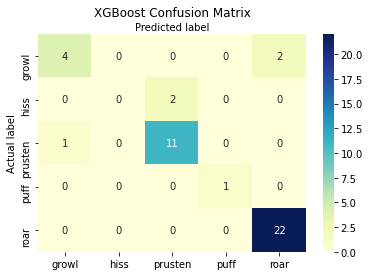

In [22]:
names = sorted(list(set(np.unique(y_test1)).union(set(y_clf1))))

print('Accuracy',clf1.score(X_test, y_test1))

cnf = confusion_matrix(y_test1, y_clf1)
fig, ax = plt.subplots()
tick_marks = np.arange(len(names))
sns.heatmap(cnf, annot = True, xticklabels = names, cmap= "YlGnBu", yticklabels = names)
ax.xaxis.set_label_position('top')
plt.title('XGBoost Confusion Matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

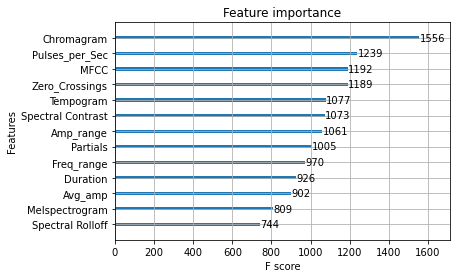

In [23]:
plot_importance(clf1)
figsize=(5,10)

## SVM

In [24]:
svm1 = SVC(probability=True)

In [25]:
svm1.fit(X_train, y_train1)

SVC(probability=True)

In [26]:
svm1.score(X_test, y_test1)

0.8604651162790697

In [27]:
y_svm1 = svm1.predict(X_test)
prob_svm1 = svm1.predict_proba(X_test)

In [28]:
print('1. Tested Calls')
print(np.unique(y_test1))
print('2. Predicted Calls')
print(np.unique(y_svm1))
print('3. False Positive')
print(set(np.unique(y_svm1))-set(np.unique(y_test1)))
print('4. False Negative')
print(set(np.unique(y_test1))-set(np.unique(y_svm1)))

1. Tested Calls
['growl' 'hiss' 'prusten' 'puff' 'roar']
2. Predicted Calls
['growl' 'prusten' 'puff' 'roar']
3. False Positive
set()
4. False Negative
{'hiss'}


Accuracy 0.8604651162790697


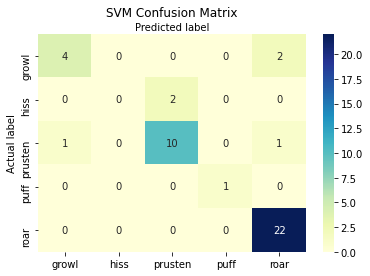

In [29]:
names = sorted(list(set(np.unique(y_test1)).union(set(y_svm1))))

print('Accuracy',svm1.score(X_test, y_test1))

cnf = confusion_matrix(y_test1, y_svm1)
fig, ax = plt.subplots()
tick_marks = np.arange(len(names))
sns.heatmap(cnf, annot = True, xticklabels = names, cmap= "YlGnBu", yticklabels = names)
ax.xaxis.set_label_position('top')
plt.title('SVM Confusion Matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

In [30]:
pred_df = pd.DataFrame(X_test.copy())
pred_df = pred_df.drop(['Partials', 'Zero_Crossings', 'Duration', 'Amp_range', 'Avg_amp',
       'Freq_range', 'Pulses_per_Sec', 'MFCC', 'Spectral Rolloff',
       'Melspectrogram', 'Spectral Contrast', 'Chromagram', 'Tempogram'], axis=1)
pred_df['File Name'] = df['File Name']
pred_df['Target'] = y_test1
pred_df[svm1.classes_[0]] = prob_svm1[:,0] 
pred_df[svm1.classes_[1]] = prob_svm1[:,1]
pred_df[svm1.classes_[2]] = prob_svm1[:,2]
pred_df[svm1.classes_[3]] = prob_svm1[:,3]
pred_df[svm1.classes_[4]] = prob_svm1[:,4]
pred_df[svm1.classes_[5]] = prob_svm1[:,5]
pred_df['Predicted'] = y_svm1
pred_df = pred_df[pred_df['Target'] != pred_df['Predicted']]
pred_df.to_csv('Mislabeled Panterinae Calls With SVM.csv', index=False)
pred_df.head(15)

,File Name,Target,Mew,growl,hiss,prusten,puff,roar,Predicted
573,LG1,growl,0.065004,0.273108,0.015987,0.016626,0.049120,0.580154,roar
407,Jaguar-Prusten-1,prusten,0.013055,0.444072,0.024558,0.237247,0.042519,0.238550,growl
576,LG2,growl,0.012610,0.325425,0.021076,0.232034,0.055797,0.353058,roar
401,CL-Prusten-10,prusten,0.009774,0.051372,0.024059,0.370828,0.010746,0.533220,roar
372,CL-Hiss,hiss,0.017037,0.023004,0.263298,0.643143,0.023865,0.029653,prusten
374,CL-Hiss,hiss,0.014261,0.021044,0.236319,0.690848,0.017615,0.019914,prusten


## Naive Bayes

In [31]:
nb1 = GaussianNB()

In [32]:
nb1.fit(X_train, y_train1)

GaussianNB()

In [33]:
nb1.score(X_test, y_test1)

0.6976744186046512

In [34]:
y_nb1 = nb1.predict(X_test)
prob_nb1 = nb1.predict_proba(X_test)

In [35]:
print('1. Tested Calls')
print(np.unique(y_test1))
print('2. Predicted Calls')
print(np.unique(y_nb1))
print('3. Not tested for but predicted')
print(set(np.unique(y_nb1))-set(np.unique(y_test1)))
print('4. Tested for but not predicted')
print(set(np.unique(y_test1))-set(np.unique(y_nb1)))

1. Tested Calls
['growl' 'hiss' 'prusten' 'puff' 'roar']
2. Predicted Calls
['growl' 'prusten' 'puff' 'roar']
3. Not tested for but predicted
set()
4. Tested for but not predicted
{'hiss'}


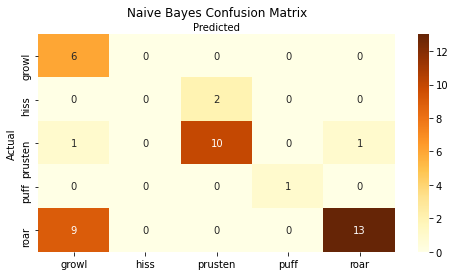

Accuracy 0.6976744186046512


In [36]:
names_nb = sorted(list(set(np.unique(y_test1)).union(set(y_nb1))))
cnf = confusion_matrix(y_test1, y_nb1)
fig, ax = plt.subplots(figsize=(8,4))

sns.heatmap(cnf, annot=True, xticklabels=names_nb, yticklabels=names_nb,cmap= "YlOrBr")
plt.title('Naive Bayes Confusion Matrix')
ax.xaxis.set_label_position('top')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)
print('Accuracy',nb1.score(X_test, y_test1))

In [37]:
pred_df = pd.DataFrame(X_test.copy())
pred_df = pred_df.drop(['Partials', 'Zero_Crossings', 'Duration', 'Amp_range', 'Avg_amp',
       'Freq_range', 'Pulses_per_Sec', 'MFCC', 'Spectral Rolloff',
       'Melspectrogram', 'Spectral Contrast', 'Chromagram', 'Tempogram'], axis=1)
pred_df['File Name'] = df['File Name']
pred_df['Target'] = y_test1
pred_df[svm1.classes_[0]] = prob_nb1[:,0] 
pred_df[svm1.classes_[1]] = prob_nb1[:,1]
pred_df[svm1.classes_[2]] = prob_nb1[:,2]
pred_df[svm1.classes_[3]] = prob_nb1[:,3]
pred_df[svm1.classes_[4]] = prob_nb1[:,4]
pred_df[svm1.classes_[5]] = prob_nb1[:,5]
pred_df['Predicted'] = y_nb1
pred_df = pred_df[pred_df['Target'] != pred_df['Predicted']]
pred_df.to_csv('Mislabeled Panterinae Calls With Naive Bayes.csv', index=False)
pred_df.head(15)

,File Name,Target,Mew,growl,hiss,prusten,puff,roar,Predicted
435,Leopard roaring sequence 4,roar,2.298912e-287,9.916778e-01,0.000000e+00,0.000000e+00,0.000000e+00,8.322226e-03,growl
407,Jaguar-Prusten-1,prusten,0.000000e+00,9.917149e-01,0.000000e+00,4.918524e-11,0.000000e+00,8.285053e-03,growl
605,Lion Roaring Sequence_19,roar,0.000000e+00,9.892184e-01,0.000000e+00,0.000000e+00,0.000000e+00,1.078159e-02,growl
591,Lion Roaring Sequence_10,roar,2.033057e-143,6.099523e-01,0.000000e+00,0.000000e+00,0.000000e+00,3.900477e-01,growl
585,Lion Roaring Sequence_5,roar,2.381094e-226,9.921562e-01,0.000000e+00,0.000000e+00,0.000000e+00,7.843764e-03,growl
420,Jaguar-Roar-2,roar,8.683888e-65,5.903876e-01,0.000000e+00,1.509058e-146,0.000000e+00,4.096124e-01,growl
581,Lion Roaring Sequence_1,roar,1.855343e-136,8.221171e-01,0.000000e+00,0.000000e+00,0.000000e+00,1.778829e-01,growl
401,CL-Prusten-10,prusten,0.000000e+00,2.645948e-02,0.000000e+00,9.304610e-10,0.000000e+00,9.735405e-01,roar
583,Lion Roaring Sequence_3,roar,1.072038e-318,7.391415e-01,0.000000e+00,0.000000e+00,0.000000e+00,2.608585e-01,growl
592,Lion Roaring Sequence_11,roar,4.617787e-308,9.970950e-01,0.000000e+00,0.000000e+00,0.000000e+00,2.904966e-03,growl


## Logistic Regression

In [38]:
lr1 = LogisticRegression(solver='liblinear', multi_class='ovr',class_weight="balanced")

In [39]:
lr1.fit(X_train,y_train1)

LogisticRegression(class_weight='balanced', multi_class='ovr',
                   solver='liblinear')

In [40]:
lr1.score(X_test, y_test1)

0.8604651162790697

In [41]:
y_lr1 = lr1.predict(X_test)
prob_lr1 = lr1.predict_proba(X_test)

In [42]:
print('1. Tested Calls')
print(np.unique(y_test1))
print('2. Predicted Calls')
print(np.unique(y_lr1))
print('3. Not tested for but predicted')
print(set(np.unique(y_lr1))-set(np.unique(y_test1)))
print('4. Tested for but not predicted')
print(set(np.unique(y_test1))-set(np.unique(y_lr1)))

1. Tested Calls
['growl' 'hiss' 'prusten' 'puff' 'roar']
2. Predicted Calls
['growl' 'hiss' 'prusten' 'puff' 'roar']
3. Not tested for but predicted
set()
4. Tested for but not predicted
set()


Accuracy 0.8604651162790697


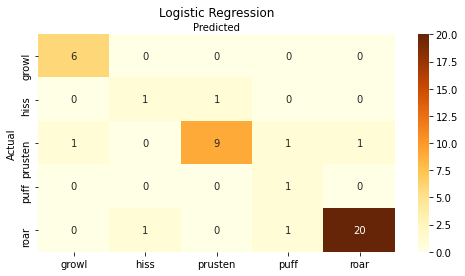

In [43]:
names_lr = sorted(list(set(np.unique(y_test1)).union(set(y_lr1))))
cnf = confusion_matrix(y_test1, y_lr1)
fig, ax = plt.subplots(figsize=(8,4))

print('Accuracy',lr1.score(X_test, y_test1))

sns.heatmap(cnf, annot=True, xticklabels=names_lr, yticklabels=names_lr,cmap= "YlOrBr")
plt.title('Logistic Regression')
ax.xaxis.set_label_position('top')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

In [44]:
pred_df = pd.DataFrame(X_test.copy())
pred_df = pred_df.drop(['Partials', 'Zero_Crossings', 'Duration', 'Amp_range', 'Avg_amp',
       'Freq_range', 'Pulses_per_Sec', 'MFCC', 'Spectral Rolloff',
       'Melspectrogram', 'Spectral Contrast', 'Chromagram', 'Tempogram'], axis=1)
pred_df['File Name'] = df['File Name']
pred_df['Target'] = y_test1
pred_df[lr1.classes_[0]] = prob_lr1[:,0] 
pred_df[lr1.classes_[1]] = prob_lr1[:,1]
pred_df[lr1.classes_[2]] = prob_lr1[:,2]
pred_df[lr1.classes_[3]] = prob_lr1[:,3]
pred_df[lr1.classes_[4]] = prob_lr1[:,4]
pred_df[lr1.classes_[5]] = prob_lr1[:,5]
pred_df['Predicted'] = y_lr1
pred_df = pred_df[pred_df['Target'] != pred_df['Predicted']]
pred_df.to_csv('Mislabeled Panterinae Calls With Logistic Regression.csv', index=False)
pred_df.head(15)

,File Name,Target,Mew,growl,hiss,prusten,puff,roar,Predicted
407,Jaguar-Prusten-1,prusten,0.014478,0.682299,0.037173,0.179413,0.047195,0.039443,growl
408,Jaguar-Prusten-1,prusten,0.032419,0.050453,0.053501,0.363560,0.374004,0.126064,puff
425,Jaguar-Roar-4,roar,0.245382,0.089348,0.262903,0.244034,0.042119,0.116214,hiss
446,Leopard roaring sequence 10d,roar,0.017737,0.084366,0.000026,0.072782,0.561371,0.263718,puff
401,CL-Prusten-10,prusten,0.011343,0.017614,0.012913,0.446081,0.002702,0.509347,roar
374,CL-Hiss,hiss,0.021152,0.037110,0.430554,0.467986,0.004450,0.038748,prusten


## KNN

In [45]:
knn1 = KNeighborsClassifier()

In [46]:
knn1.fit(X_train, y_train1)

KNeighborsClassifier()

In [48]:
knn1.score(X_test, y_test1)

0.8604651162790697

In [49]:
y_knn1 = knn1.predict(X_test)
prob_knn1 = knn1.predict_proba(X_test)

In [50]:
print('1. Tested Calls')
print(np.unique(y_test1))
print('2. Predicted Calls')
print(np.unique(y_knn1))
print('3. Not tested for but predicted')
print(set(np.unique(y_knn1))-set(np.unique(y_test1)))
print('4. Tested for but not predicted')
print(set(np.unique(y_test1))-set(np.unique(y_knn1)))

1. Tested Calls
['growl' 'hiss' 'prusten' 'puff' 'roar']
2. Predicted Calls
['growl' 'hiss' 'prusten' 'puff' 'roar']
3. Not tested for but predicted
set()
4. Tested for but not predicted
set()


Accuracy 0.8604651162790697


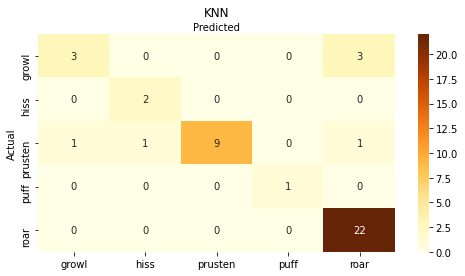

In [51]:
names_knn = sorted(list(set(np.unique(y_test1)).union(set(y_knn1))))
cnf = confusion_matrix(y_test1, y_knn1)
fig, ax = plt.subplots(figsize=(8,4))

print('Accuracy',knn1.score(X_test, y_test1))

sns.heatmap(cnf, annot=True, xticklabels=names_knn, yticklabels=names_knn,cmap= "YlOrBr")
plt.title('KNN')
ax.xaxis.set_label_position('top')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)


In [52]:
pred_df = pd.DataFrame(X_test.copy())
pred_df = pred_df.drop(['Partials', 'Zero_Crossings', 'Duration', 'Amp_range', 'Avg_amp',
       'Freq_range', 'Pulses_per_Sec', 'MFCC', 'Spectral Rolloff',
       'Melspectrogram', 'Spectral Contrast', 'Chromagram', 'Tempogram'], axis=1)
pred_df['File Name'] = df['File Name']
pred_df['Target'] = y_test1
pred_df[knn1.classes_[0]] = prob_knn1[:,0] 
pred_df[knn1.classes_[1]] = prob_knn1[:,1]
pred_df[knn1.classes_[2]] = prob_knn1[:,2]
pred_df[knn1.classes_[3]] = prob_knn1[:,3]
pred_df[knn1.classes_[4]] = prob_knn1[:,4]
pred_df[knn1.classes_[5]] = prob_knn1[:,5]
pred_df['Predicted'] = y_knn1
pred_df = pred_df[pred_df['Target'] != pred_df['Predicted']]
pred_df.to_csv('Mislabeled Panterinae Calls With KNN.csv', index=False)
pred_df.head(15)

,File Name,Target,Mew,growl,hiss,prusten,puff,roar,Predicted
573,LG1,growl,0.2,0.2,0.0,0.0,0.0,0.6,roar
407,Jaguar-Prusten-1,prusten,0.0,0.4,0.0,0.4,0.0,0.2,growl
479,Snow Leopard Prusten_2,prusten,0.0,0.0,0.8,0.2,0.0,0.0,hiss
576,LG2,growl,0.0,0.2,0.0,0.2,0.0,0.6,roar
401,CL-Prusten-10,prusten,0.0,0.0,0.0,0.4,0.0,0.6,roar
459,Leopard_growl_3,growl,0.0,0.4,0.0,0.0,0.0,0.6,roar


## Decision Tree Classifier

In [53]:
dt1 = DecisionTreeClassifier()

In [54]:
dt1.fit(X_train, y_train1)

DecisionTreeClassifier()

In [56]:
dt1.score(X_test, y_test1)

0.7674418604651163

In [57]:
y_dt1 = dt1.predict(X_test)
prob_dt1 = dt1.predict_proba(X_test)

In [58]:
print('1. Tested Calls')
print(np.unique(y_test1))
print('2. Predicted Calls')
print(np.unique(y_dt1))
print('3. Not tested for but predicted')
print(set(np.unique(y_dt1))-set(np.unique(y_test1)))
print('4. Tested for but not predicted')
print(set(np.unique(y_test1))-set(np.unique(y_dt1)))

1. Tested Calls
['growl' 'hiss' 'prusten' 'puff' 'roar']
2. Predicted Calls
['Mew' 'growl' 'hiss' 'prusten' 'puff' 'roar']
3. Not tested for but predicted
{'Mew'}
4. Tested for but not predicted
set()


Accuracy 0.7674418604651163


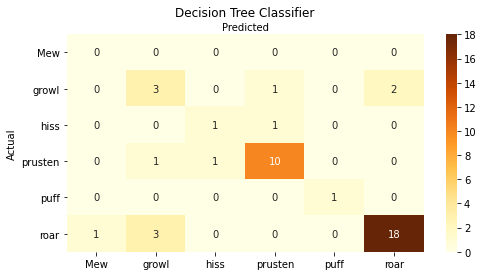

In [59]:
names_cart = sorted(list(set(np.unique(y_test1)).union(set(y_dt1))))
cnf = confusion_matrix(y_test1, y_dt1)
fig, ax = plt.subplots(figsize=(8,4))

print('Accuracy',dt1.score(X_test, y_test1))

sns.heatmap(cnf, annot=True, xticklabels=names_cart, yticklabels=names_cart,cmap= "YlOrBr")
plt.title('Decision Tree Classifier')
ax.xaxis.set_label_position('top')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)


## Random Forest Classifier

In [60]:
rf1 = RandomForestClassifier()

In [61]:
rf1.fit(X_train, y_train1)

RandomForestClassifier()

In [63]:
rf1.score(X_test, y_test1)

0.8837209302325582

In [64]:
y_rf1 = rf1.predict(X_test)
prob_rf1 = rf1.predict_proba(X_test)

In [65]:
print('1. Tested Calls')
print(np.unique(y_test1))
print('2. Predicted Calls')
print(np.unique(y_rf1))
print('3. Not tested for but predicted')
print(set(np.unique(y_rf1))-set(np.unique(y_test1)))
print('4. Tested for but not predicted')
print(set(np.unique(y_test1))-set(np.unique(y_rf1)))

1. Tested Calls
['growl' 'hiss' 'prusten' 'puff' 'roar']
2. Predicted Calls
['growl' 'prusten' 'puff' 'roar']
3. Not tested for but predicted
set()
4. Tested for but not predicted
{'hiss'}


Accuracy 0.8837209302325582


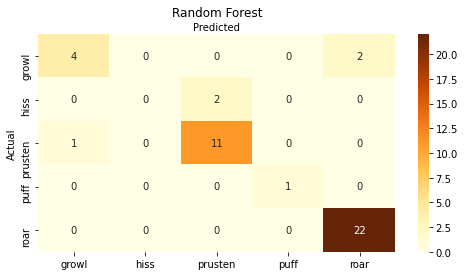

In [66]:
names_rf = sorted(list(set(np.unique(y_test1)).union(set(y_rf1))))
cnf = confusion_matrix(y_test1, y_rf1)
fig, ax = plt.subplots(figsize=(8,4))

print('Accuracy',rf1.score(X_test, y_test1))

sns.heatmap(cnf, annot=True, xticklabels=names_rf, yticklabels=names_rf,cmap= "YlOrBr")
plt.title('Random Forest')
ax.xaxis.set_label_position('top')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)


In [67]:
pred_df = pd.DataFrame(X_test.copy())
pred_df = pred_df.drop(['Partials', 'Zero_Crossings', 'Duration', 'Amp_range', 'Avg_amp',
       'Freq_range', 'Pulses_per_Sec', 'MFCC', 'Spectral Rolloff',
       'Melspectrogram', 'Spectral Contrast', 'Chromagram', 'Tempogram'], axis=1)
pred_df['File Name'] = df['File Name']
pred_df['Target'] = y_test1
pred_df[rf1.classes_[0]] = prob_rf1[:,0] 
pred_df[rf1.classes_[1]] = prob_rf1[:,1]
pred_df[rf1.classes_[2]] = prob_rf1[:,2]
pred_df[rf1.classes_[3]] = prob_rf1[:,3]
pred_df[rf1.classes_[4]] = prob_rf1[:,4]
pred_df[rf1.classes_[5]] = prob_rf1[:,5]
pred_df['Predicted'] = y_rf1
pred_df = pred_df[pred_df['Target'] != pred_df['Predicted']]
pred_df.to_csv('Mislabeled Panterinae Calls With Random Forest.csv', index=False)
pred_df.head(15)

,File Name,Target,Mew,growl,hiss,prusten,puff,roar,Predicted
573,LG1,growl,0.10,0.44,0.00,0.00,0.00,0.46,roar
407,Jaguar-Prusten-1,prusten,0.00,0.51,0.07,0.34,0.00,0.08,growl
459,Leopard_growl_3,growl,0.03,0.32,0.00,0.02,0.01,0.62,roar
372,CL-Hiss,hiss,0.00,0.02,0.39,0.55,0.00,0.04,prusten
374,CL-Hiss,hiss,0.00,0.00,0.24,0.76,0.00,0.00,prusten


In [68]:
#The data is unbalanced, this could be fixed by updating the class weights 
#Or getting more varied data
df['Call'].value_counts()

roar       65
prusten    44
growl      20
hiss        6
puff        5
Mew         3
Name: Call, dtype: int64

# Species Classification

## Splitting data

In [69]:
y_train2 = y_train.Species
y_test2 = y_test.Species

In [70]:
## LightGBM

In [71]:
import lightgbm as lgb
lgb2 = lgb.LGBMClassifier()
lgb2.fit(X_train, y_train2)

LGBMClassifier()

In [73]:
lgb2.score(X_test,y_test2)

0.7674418604651163

## XGBoost

In [74]:
parameters = dict(
    objective='multi:softprob',
    random_state = 30,
    max_depth=9,
    learning_rate=0.01,
    subsample=0.8,
    colsample_bytree=0.4,
    tree_method='gpu_hist')
#eval_metric='mlogloss'

clf2 = XGBClassifier(**parameters, n_estimators=1200)

In [75]:
clf2.fit(X_train, y_train2)

C:\Users\exant\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[02:30:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.4, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=9,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1200, n_jobs=12, num_parallel_tree=1,
              objective='multi:softprob', random_state=30, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=0.8,
              tree_method='gpu_hist', validate_parameters=1, verbosity=None)

In [77]:
clf2.score(X_test,y_test2)

0.813953488372093

In [78]:
y_clf2 = clf2.predict(X_test)
prob_clf2 = clf2.predict_proba(X_test)

In [79]:
print('1. Tested Species')
print(np.unique(y_test2))
print('2. Predicted Species')
print(np.unique(y_clf2))
print('3. Not tested for but predicted')
print(set(np.unique(y_clf2))-set(np.unique(y_test2)))
print('4. Tested for but not predicted')
print(set(np.unique(y_test2))-set(np.unique(y_clf2)))

1. Tested Species
['Clouded leopard' 'Jaguar' 'Leopard' 'Lion' 'Snow leopard']
2. Predicted Species
['Clouded leopard' 'Jaguar' 'Leopard' 'Lion']
3. Not tested for but predicted
set()
4. Tested for but not predicted
{'Snow leopard'}


Accuracy 0.813953488372093


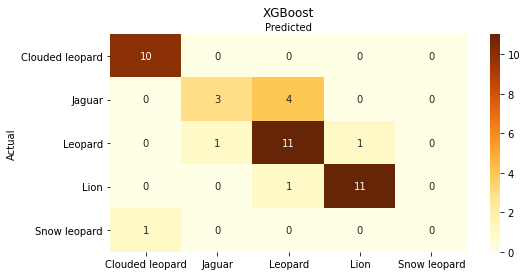

In [80]:
names = sorted(list(set(np.unique(y_test2)).union(set(y_clf2))))
cnf = confusion_matrix(y_test2, y_clf2)
fig, ax = plt.subplots(figsize=(8,4))

print('Accuracy',clf2.score(X_test, y_test2))

sns.heatmap(cnf, annot=True, xticklabels=names, yticklabels=names,cmap= "YlOrBr")
plt.title('XGBoost')
ax.xaxis.set_label_position('top')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)


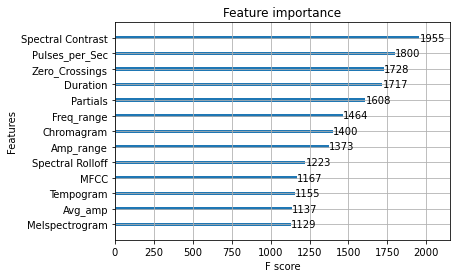

In [81]:
plot_importance(clf2)
figsize=(8,4)

## SVM

In [82]:
svm2 = SVC(probability=True)

In [83]:
svm2.fit(X_train, y_train2)

SVC(probability=True)

In [85]:
svm2.score(X_test, y_test2)

0.813953488372093

In [86]:
y_svm2=svm2.predict(X_test)
prob_svm2 = svm2.predict_proba(X_test)

In [87]:
print('1. Tested Species')
print(np.unique(y_test2))
print('2. Predicted Species')
print(np.unique(y_svm2))
print('3. False Positive')
print(set(np.unique(y_svm2))-set(np.unique(y_test2)))
print('4. False Negative')
print(set(np.unique(y_test2))-set(np.unique(y_svm2)))

1. Tested Species
['Clouded leopard' 'Jaguar' 'Leopard' 'Lion' 'Snow leopard']
2. Predicted Species
['Clouded leopard' 'Jaguar' 'Leopard' 'Lion']
3. False Positive
set()
4. False Negative
{'Snow leopard'}


Accuracy 0.813953488372093


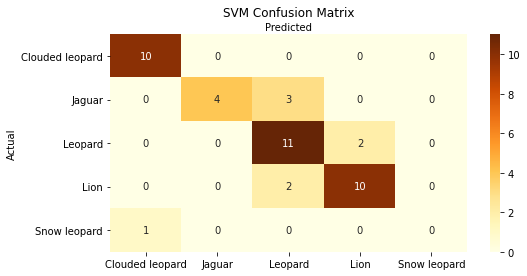

In [88]:
names_svc = sorted(list(set(np.unique(y_test2)).union(set(y_svm2))))
cnf = confusion_matrix(y_test2, y_svm2)
fig, ax = plt.subplots(figsize=(8,4))

print('Accuracy',svm2.score(X_test, y_test2))

sns.heatmap(cnf, annot=True, xticklabels=names_svc, yticklabels=names_svc,cmap= "YlOrBr")
plt.title('SVM Confusion Matrix')
ax.xaxis.set_label_position('top')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)



## Naive Bayes

In [89]:
nb2 = GaussianNB()

In [90]:
nb2.fit(X_train, y_train2)

GaussianNB()

In [92]:
nb2.score(X_test, y_test2)

0.813953488372093

In [93]:
y_nb2 = nb2.predict(X_test)
prob_nb2 = nb2.predict_proba(X_test)

In [94]:
print('1. Tested Species')
print(np.unique(y_test2))
print('2. Predicted Species')
print(np.unique(y_nb2))
print('3. Not tested for but predicted')
print(set(np.unique(y_nb2))-set(np.unique(y_test2)))
print('4. Tested for but not predicted')
print(set(np.unique(y_test2))-set(np.unique(y_nb2)))

1. Tested Species
['Clouded leopard' 'Jaguar' 'Leopard' 'Lion' 'Snow leopard']
2. Predicted Species
['Clouded leopard' 'Jaguar' 'Leopard' 'Lion' 'Snow leopard']
3. Not tested for but predicted
set()
4. Tested for but not predicted
set()


Accuracy 0.813953488372093


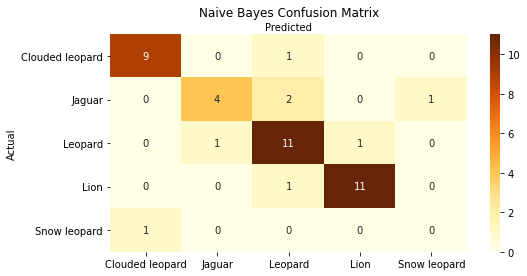

In [95]:
names_nb = sorted(list(set(np.unique(y_test2)).union(set(y_nb2))))
cnf = confusion_matrix(y_test2, y_nb2)
fig, ax = plt.subplots(figsize=(8,4))

print('Accuracy',nb2.score(X_test, y_test2))

sns.heatmap(cnf, annot=True, xticklabels=names_nb, yticklabels=names_nb,cmap= "YlOrBr")
plt.title('Naive Bayes Confusion Matrix')
ax.xaxis.set_label_position('top')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)


## Logistic Regression

In [96]:
lr2 = LogisticRegression(solver='liblinear', multi_class='ovr')

In [97]:
lr2.fit(X_train,y_train2)

LogisticRegression(multi_class='ovr', solver='liblinear')

In [99]:
lr2.score(X_test, y_test2)

0.8372093023255814

In [100]:
y_lr2 = lr2.predict(X_test)
prob_lr2 = lr2.predict_proba(X_test)

In [101]:
print('1. Tested Species')
print(np.unique(y_test))
print('2. Predicted Species')
print(np.unique(y_lr2))
print('3. Not tested for but predicted')
print(set(np.unique(y_lr2))-set(np.unique(y_test)))
print('4. Tested for but not predicted')
print(set(np.unique(y_test))-set(np.unique(y_lr2)))

1. Tested Species
['Clouded leopard' 'Jaguar' 'Leopard' 'Lion' 'Snow leopard' 'growl' 'hiss'
 'prusten' 'puff' 'roar']
2. Predicted Species
['Clouded leopard' 'Jaguar' 'Leopard' 'Lion']
3. Not tested for but predicted
set()
4. Tested for but not predicted
{'hiss', 'puff', 'Snow leopard', 'roar', 'growl', 'prusten'}


Accuracy 0.8372093023255814


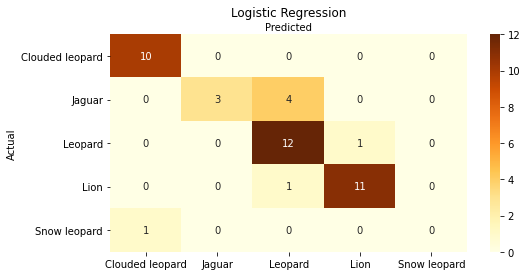

In [102]:
names_lr = sorted(list(set(np.unique(y_test2)).union(set(y_lr2))))
cnf = confusion_matrix(y_test2, y_lr2)
fig, ax = plt.subplots(figsize=(8,4))

print('Accuracy',lr2.score(X_test, y_test2))

sns.heatmap(cnf, annot=True, xticklabels=names_lr, yticklabels=names_lr,cmap= "YlOrBr")
plt.title('Logistic Regression')
ax.xaxis.set_label_position('top')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)


## KNN

In [103]:
knn2 = KNeighborsClassifier()

In [104]:
knn2.fit(X_train, y_train2)

KNeighborsClassifier()

In [106]:
knn2.score(X_test, y_test2)

0.7674418604651163

In [107]:
y_knn2 = knn2.predict(X_test)
prob_knn2 = knn2.predict_proba(X_test)

In [108]:
print('1. Tested Species')
print(np.unique(y_test2))
print('2. Predicted Species')
print(np.unique(y_knn2))
print('3. Not tested for but predicted')
print(set(np.unique(y_knn2))-set(np.unique(y_test2)))
print('4. Tested for but not predicted')
print(set(np.unique(y_test2))-set(np.unique(y_knn2)))

1. Tested Species
['Clouded leopard' 'Jaguar' 'Leopard' 'Lion' 'Snow leopard']
2. Predicted Species
['Clouded leopard' 'Jaguar' 'Leopard' 'Lion']
3. Not tested for but predicted
set()
4. Tested for but not predicted
{'Snow leopard'}


Accuracy 0.7674418604651163


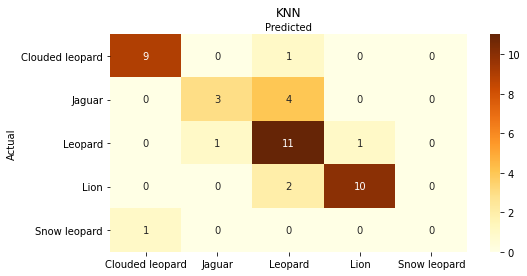

In [109]:
names_knn = sorted(list(set(np.unique(y_test2)).union(set(y_knn2))))
cnf = confusion_matrix(y_test2, y_knn2)
fig, ax = plt.subplots(figsize=(8,4))

print('Accuracy',knn2.score(X_test, y_test2))

sns.heatmap(cnf, annot=True, xticklabels=names_knn, yticklabels=names_knn,cmap= "YlOrBr")
plt.title('KNN')
ax.xaxis.set_label_position('top')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)


## Decision Tree Classifier

In [110]:
dt2 = DecisionTreeClassifier()

In [111]:
dt2.fit(X_train, y_train2)

DecisionTreeClassifier()

In [113]:
dt2.score(X_test, y_test2)

0.8837209302325582

In [114]:
y_dt2 = dt2.predict(X_test)
prob_dt2 = dt2.predict_proba(X_test)

In [115]:
print('1. Tested Species')
print(np.unique(y_test2))
print('2. Predicted Species')
print(np.unique(y_dt2))
print('3. Not tested for but predicted')
print(set(np.unique(y_dt2))-set(np.unique(y_test2)))
print('4. Tested for but not predicted')
print(set(np.unique(y_test2))-set(np.unique(y_dt2)))

1. Tested Species
['Clouded leopard' 'Jaguar' 'Leopard' 'Lion' 'Snow leopard']
2. Predicted Species
['Clouded leopard' 'Jaguar' 'Leopard' 'Lion' 'Snow leopard']
3. Not tested for but predicted
set()
4. Tested for but not predicted
set()


Accuracy 0.8837209302325582


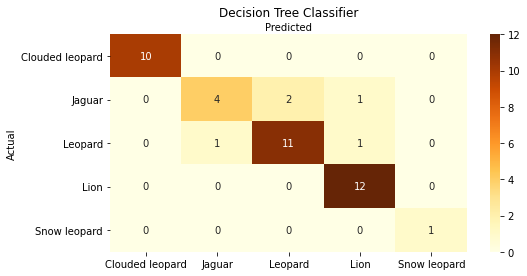

In [116]:
names_cart = sorted(list(set(np.unique(y_test2)).union(set(y_dt2))))
cnf = confusion_matrix(y_test2, y_dt2)
fig, ax = plt.subplots(figsize=(8,4))

print('Accuracy',dt2.score(X_test, y_test2))

sns.heatmap(cnf, annot=True, xticklabels=names_cart, yticklabels=names_cart,cmap= "YlOrBr")
plt.title('Decision Tree Classifier')
ax.xaxis.set_label_position('top')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)


## Random Forest Classifier

In [117]:
rf2 = RandomForestClassifier()

In [118]:
rf2.fit(X_train, y_train2)

RandomForestClassifier()

In [120]:
rf2.score(X_test, y_test2)

0.8604651162790697

In [121]:
y_rf2 = rf2.predict(X_test)
prob_rf2 = rf2.predict_proba(X_test)

In [122]:
print('1. Tested Species')
print(np.unique(y_test2))
print('2. Predicted Species')
print(np.unique(y_rf2))
print('3. Not tested for but predicted')
print(set(np.unique(y_rf2))-set(np.unique(y_test2)))
print('4. Tested for but not predicted')
print(set(np.unique(y_test2))-set(np.unique(y_rf2)))

1. Tested Species
['Clouded leopard' 'Jaguar' 'Leopard' 'Lion' 'Snow leopard']
2. Predicted Species
['Clouded leopard' 'Jaguar' 'Leopard' 'Lion' 'Snow leopard']
3. Not tested for but predicted
set()
4. Tested for but not predicted
set()


Accuracy 0.8604651162790697


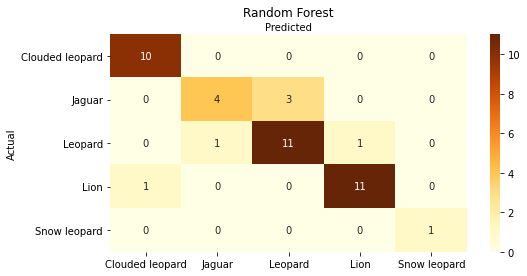

In [123]:
names_rf = sorted(list(set(np.unique(y_test2)).union(set(y_rf2))))
cnf = confusion_matrix(y_test2, y_rf2)
fig, ax = plt.subplots(figsize=(8,4))

print('Accuracy',rf2.score(X_test, y_test2))

sns.heatmap(cnf, annot=True, xticklabels=names_rf, yticklabels=names_rf,cmap= "YlOrBr")
plt.title('Random Forest')
ax.xaxis.set_label_position('top')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

In [124]:
df_test = pd.DataFrame(X_test.copy())
df_test = df_test.drop(['Partials', 'Zero_Crossings', 'Duration', 'Amp_range', 'Avg_amp',
       'Freq_range', 'Pulses_per_Sec', 'MFCC', 'Spectral Rolloff',
       'Melspectrogram', 'Spectral Contrast', 'Chromagram', 'Tempogram'], axis=1)
df_test['File Name'] = df['File Name']
df_test['Target'] = y_test2
df_test[rf2.classes_[0]] = prob_rf2[:,0] 
df_test[rf2.classes_[1]] = prob_rf2[:,1]
df_test[rf2.classes_[2]] = prob_rf2[:,2]
df_test[rf2.classes_[3]] = prob_rf2[:,3]
df_test[rf2.classes_[4]] = prob_rf2[:,4]
df_test['Predicted'] = y_rf2
df_test = df_test[df_test['Target'] != df_test['Predicted']]
df_test.to_csv('Mislabeled Panterinae Species With Random Forest.csv', index=False)
df_test.head(15)

,File Name,Target,Clouded leopard,Jaguar,Leopard,Lion,Snow leopard,Predicted
435,Leopard roaring sequence 4,Leopard,0.01,0.43,0.21,0.35,0.00,Jaguar
430,Leopard roaring sequence 1,Leopard,0.03,0.00,0.29,0.50,0.18,Lion
407,Jaguar-Prusten-1,Jaguar,0.14,0.22,0.39,0.14,0.11,Leopard
419,Jaguar-Roar-1,Jaguar,0.21,0.04,0.47,0.23,0.05,Leopard
420,Jaguar-Roar-2,Jaguar,0.02,0.22,0.53,0.18,0.05,Leopard
576,LG2,Lion,0.25,0.25,0.20,0.20,0.10,Clouded leopard


#The data is unbalanced, this could be fixed by updating the class weights 
#Or getting more varied data
df2['Species'].value_counts()